# MAS climate downscale for the Southeast Asia

This [Jupyter Notebook](https://jupyter.org/) is coded with Python 3.9.7 for the climate downscale project funded by The Monetary Authority of Singapore, focusing on the statistical downscale for the climate projections in the Southeast Asia.<br>
Any questions regarding the code can be addressed to **Dr Shuai Wang** at **shuai.wang@imperial.ac.uk**. <br>
<br>
**Contents:** <br>
1. Prepare models
2. Activate CUPs for parallel computing
3. Choose a downscale model
4. Downscale for regions
5. Results visualisation


## Prepare models

Imports some global libraries

In [1]:
# close warming info
import warnings
warnings.filterwarnings("ignore")
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")  # sklearn

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

import numpy as np

from utils import get_sample_data

import xarray as xr

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from skdownscale.pointwise_models import PureAnalog, AnalogRegression
from skdownscale.pointwise_models import BcsdTemperature, BcsdPrecipitation
from skdownscale.pointwise_models import QuantileMappingReressor

from skdownscale.pointwise_models import PointWiseDownscaler
from dask.diagnostics import ProgressBar

sns.set(style='darkgrid')

## Activate CUPs for parallel computing

Start a Dask Cluster. This cluster will be used when it comes time to load input data and train/predict downscaling models. <br>
**NB:** The program can automatically choose an optimal number of CUPs based on the compute configurations.

In [2]:
from dask.distributed import Client

client = Client()
# client

## Choose a downscale model

Five difference downscale models are prepared. To make a choice, simply un-comment the line with the prefered model.<br>
1. Quantile Mapping
2. Pure Analog (best-analog)
3. Pure Analog (sample-analog)
4. Random Forest
5. Temperature bias correction

In [3]:
model = PointWiseDownscaler(QuantileMappingReressor())
# model = PointWiseDownscaler(PureAnalog(kind='best_analog', n_analogs=1))
# model = PointWiseDownscaler(PureAnalog(kind='sample_analogs', n_analogs=10))
# model = PointWiseDownscaler(RandomForestRegressor(random_state=0))
# model = PointWiseDownscaler(BcsdTemperature(return_anoms=False))

## Downscale for regions

### SET: training and predicting periods
The exmaple below means you want to train the model for 2005-2007 and predict for 2053-2055

In [4]:
TRAIN_START_YEAR = 2005
TRAIN_END_YEAR   = 2007

PRED_START_YEAR  = 2053
PRED_END_YEAR    = 2055

###
train_slice = slice(str(TRAIN_START_YEAR), str(TRAIN_END_YEAR))  # train time range   '1981', '1983'
holdout_slice = slice(str(PRED_START_YEAR), str(PRED_END_YEAR))  # prediction time range

### SET: variables
There are four climate variables that can be chosen for downscaling<br>
1. `Precipitation` *(mm per day)* the daily accumulated precipitation
2. `Temperature` *(C)* the daily maximum temperature
3. `Wind` *(m/s)* the daily averaged wind
4. `Surge` *(m)* the daily averaged wind-drived surge height 
**NB:** uncomment one VAR per downscaling run

In [5]:
VAR = 'Precipitation'
# VAR = 'Temperature'
# VAR = 'Wind'
# VAR = 'Surge'

### SET: downscale region
The example below sets the region boxing Malaysia<br>
1. NNN: northmost latitude
2. SSS: southmost latitude
3. WWW: westmost longitude
4. EEE: eastmost longitude

In [6]:
NNN,SSS,WWW,EEE = 8.5,-0.5,98.5,120.5

Download the historical observation from [Google Earth Engine ERA5 archive](https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_DAILY)<br>
To download the data, a google account is required.

In [7]:
# bounding box of downscaling region
lon_slice = slice(WWW, EEE) 
lat_slice = slice(NNN, SSS)

# chunk shape for dask execution (time must be contiguous, ie -1)
chunks = {'lat': 10, 'lon': 10, 'time': -1}

import ee
import wxee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

# singapore: 1.3521° N, 103.8198° E
region = ee.Geometry.Polygon([[
    [WWW, NNN],
    [WWW, SSS],
    [EEE, SSS],
    [EEE, NNN]
]])
if VAR == 'Precipitation':
    era5_2mt = ee.ImageCollection('ECMWF/ERA5/DAILY')
    era5_2mt = era5_2mt.select('total_precipitation')
    era5_2mt = era5_2mt.filterDate(str(TRAIN_START_YEAR)+"-01-01", str(TRAIN_END_YEAR+1)+"-01-01") # here we should add one more time for the end point
    obs_subset=era5_2mt.wx.to_xarray(region=region)
    obs_subset=obs_subset['total_precipitation']
    obs_subset=obs_subset.rename({'x': 'lon','y': 'lat'})
    
if VAR == 'Temperature':
    era5_2mt = ee.ImageCollection('ECMWF/ERA5/DAILY')
    era5_2mt = era5_2mt.select('maximum_2m_air_temperature')
    era5_2mt = era5_2mt.filterDate(str(TRAIN_START_YEAR)+"-01-01", str(TRAIN_END_YEAR+1)+"-01-01") # here we should add one more time for the end point
    obs_subset=era5_2mt.wx.to_xarray(region=region)
    obs_subset=obs_subset['maximum_2m_air_temperature']
    obs_subset=obs_subset.rename({'x': 'lon','y': 'lat'})
    
if VAR == 'Wind' or VAR == 'Surge':
    era5_2mt = ee.ImageCollection('ECMWF/ERA5/DAILY')
    era5_2mt = era5_2mt.select('u_component_of_wind_10m')
    era5_2mt = era5_2mt.filterDate(str(TRAIN_START_YEAR)+"-01-01", str(TRAIN_END_YEAR+1)+"-01-01") # here we should add one more time for the end point
    obs_subset=era5_2mt.wx.to_xarray(region=region)
    obs_subset_u=obs_subset['u_component_of_wind_10m']
    # obs_subset=obs_subset.rename({'x': 'lon','y': 'lat'})

    era5_2mt = ee.ImageCollection('ECMWF/ERA5/DAILY')
    era5_2mt = era5_2mt.select('v_component_of_wind_10m')
    era5_2mt = era5_2mt.filterDate(str(TRAIN_START_YEAR)+"-01-01", str(TRAIN_END_YEAR+1)+"-01-01") # here we should add one more time for the end point
    obs_subset=era5_2mt.wx.to_xarray(region=region)
    obs_subset_v=obs_subset['v_component_of_wind_10m']
    # obs_subset=obs_subset.rename({'x': 'lon','y': 'lat'})
    
    obs_subset = np.sqrt((obs_subset_u)**2+(obs_subset_v)**2)
    
    obs_subset=obs_subset.rename({'x': 'lon','y': 'lat'})

xdg-open: no method available for opening 'https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=Fj0kqA9uSK9p_7u-Y9fxwVrXePClO0qHw_5dbS5IZCw&code_challenge_method=S256'


Enter verification code:  4/1AX4XfWg2UPEF5sdac65QpqinjR8YXPUl-wZTbx1Q5qqvYIJimaqS1T27ZaQ



Successfully saved authorization token.


Requesting data:   0%|          | 0/1095 [00:00<?, ?it/s]

### SET: the downscale resolution<br>
Example: `CHANGE_INTERVAL=0.1` is for a resolution of `1-degree latitude * 0.1 ~ 10km`

In [8]:
CHANGE_INTERVAL=0.1#0.005

grid interpolation

In [9]:
obs_subset = obs_subset.interp(lat=np.arange(NNN, SSS-CHANGE_INTERVAL,-CHANGE_INTERVAL),lon=np.arange(WWW, EEE+CHANGE_INTERVAL,CHANGE_INTERVAL),kwargs={"fill_value": "extrapolate"})

Download climate projections

In [10]:
import intake_esm
import intake

if VAR == 'Precipitation':
    # search the cmip6 catalog
    col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
    ################################################################
    # change the member_id from r1i1p1f1 for temp to r3i1p1f1 for pr
    ################################################################
    cat = col.search(experiment_id=['historical','ssp585'], table_id='day', variable_id='pr',member_id='r3i1p1f1',
                     grid_label='gn')

    # access the data and do some cleanup
    ds_model = cat['CMIP.CSIRO-ARCCSS.ACCESS-CM2.historical.day.gn'].to_dask().squeeze(drop=True).drop(['lat_bnds', 'lon_bnds', 'time_bnds'])
    ds_model.lon.values[ds_model.lon.values > 180] -= 360
    ds_model = ds_model.roll(lon=72, roll_coords=True)

    # regional subsets, ready for downscaling
    train_subset = ds_model['pr'].sel(time=train_slice).interp_like(obs_subset.isel(time=0, drop=True), method='linear')
    train_subset['time']=pd.to_datetime(train_subset['time'].dt.strftime('%Y-%m-%d'))
    # train_subset['time'] = train_subset.indexes['time'].to_datetimeindex()
    train_subset = train_subset.resample(time='1d').mean().load(scheduler='threads').chunk(chunks)

    # access the data and do some cleanup
    ds_model = cat['ScenarioMIP.CSIRO-ARCCSS.ACCESS-CM2.ssp585.day.gn'].to_dask().squeeze(drop=True).drop(['lat_bnds', 'lon_bnds', 'time_bnds'])
    ds_model.lon.values[ds_model.lon.values > 180] -= 360
    ds_model = ds_model.roll(lon=72, roll_coords=True)

    holdout_subset = ds_model['pr'].sel(time=holdout_slice).interp_like(obs_subset.isel(time=0, drop=True), method='linear')
    holdout_subset['time']=pd.to_datetime(holdout_subset['time'].dt.strftime('%Y-%m-%d'))
    # holdout_subset['time'] = holdout_subset.indexes['time'].to_datetimeindex()
    holdout_subset = holdout_subset.resample(time='1d').mean().load(scheduler='threads').chunk(chunks)

    # convert the unit of pr in CMIP from kg m2 s-1 to m as in ERA5, * 86.4
    train_subset   = train_subset   * 86.4
    holdout_subset = holdout_subset * 86.4
    
if VAR == 'Temperature':
    # search the cmip6 catalog
    col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
    # cat = col.search(experiment_id=['historical', 'ssp585'], table_id='day', variable_id='tasmax',
    #                  grid_label='gn')
    cat = col.search(experiment_id=['historical','ssp585'], table_id='day', variable_id='tasmax',member_id='r1i1p1f1',
                     grid_label='gn')

    # access the data and do some cleanup
    ds_model = cat['CMIP.CSIRO-ARCCSS.ACCESS-CM2.historical.day.gn'].to_dask().squeeze(drop=True).drop(['height', 'lat_bnds', 'lon_bnds', 'time_bnds'])
    ds_model.lon.values[ds_model.lon.values > 180] -= 360
    ds_model = ds_model.roll(lon=72, roll_coords=True)

    # regional subsets, ready for downscaling
    train_subset = ds_model['tasmax'].sel(time=train_slice).interp_like(obs_subset.isel(time=0, drop=True), method='linear')
    train_subset['time']=pd.to_datetime(train_subset['time'].dt.strftime('%Y-%m-%d'))
    # train_subset['time'] = train_subset.indexes['time'].to_datetimeindex()
    train_subset = train_subset.resample(time='1d').mean().load(scheduler='threads').chunk(chunks)


    # access the data and do some cleanup
    ds_model = cat['ScenarioMIP.CSIRO-ARCCSS.ACCESS-CM2.ssp585.day.gn'].to_dask().squeeze(drop=True).drop(['height', 'lat_bnds', 'lon_bnds', 'time_bnds'])
    ds_model.lon.values[ds_model.lon.values > 180] -= 360
    ds_model = ds_model.roll(lon=72, roll_coords=True)

    holdout_subset = ds_model['tasmax'].sel(time=holdout_slice).interp_like(obs_subset.isel(time=0, drop=True), method='linear')
    holdout_subset['time']=pd.to_datetime(holdout_subset['time'].dt.strftime('%Y-%m-%d'))
    # holdout_subset['time'] = holdout_subset.indexes['time'].to_datetimeindex()
    holdout_subset = holdout_subset.resample(time='1d').mean().load(scheduler='threads').chunk(chunks)
    
if VAR == 'Wind' or VAR == 'Surge' :
    # search the cmip6 catalog
    col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
    # cat = col.search(experiment_id=['historical', 'ssp585'], table_id='day', variable_id='tasmax',
    #                  grid_label='gn')

    cat = col.search(experiment_id=['historical','ssp585'], table_id='day', variable_id=['uas'],member_id='r1i1p1f1',
                     grid_label='gn')
    ds_model = cat['CMIP.CSIRO-ARCCSS.ACCESS-CM2.historical.day.gn'].to_dask().squeeze(drop=True).drop(['height', 'lat_bnds', 'lon_bnds', 'time_bnds'])
    ds_model.lon.values[ds_model.lon.values > 180] -= 360
    ds_model = ds_model.roll(lon=72, roll_coords=True)
    # regional subsets, ready for downscaling
    train_subset = ds_model['uas'].sel(time=train_slice).interp_like(obs_subset.isel(time=0, drop=True), method='linear')
    train_subset['time']=pd.to_datetime(train_subset['time'].dt.strftime('%Y-%m-%d'))
    # train_subset['time'] = train_subset.indexes['time'].to_datetimeindex()
    train_subset_u = train_subset.resample(time='1d').mean().load(scheduler='threads').chunk(chunks)

    cat = col.search(experiment_id=['historical','ssp585'], table_id='day', variable_id=['vas'],member_id='r1i1p1f1',
                     grid_label='gn')
    ds_model = cat['CMIP.CSIRO-ARCCSS.ACCESS-CM2.historical.day.gn'].to_dask().squeeze(drop=True).drop(['height', 'lat_bnds', 'lon_bnds', 'time_bnds'])
    ds_model.lon.values[ds_model.lon.values > 180] -= 360
    ds_model = ds_model.roll(lon=72, roll_coords=True)
    train_subset = ds_model['vas'].sel(time=train_slice).interp_like(obs_subset.isel(time=0, drop=True), method='linear')
    train_subset['time']=pd.to_datetime(train_subset['time'].dt.strftime('%Y-%m-%d'))
    # train_subset['time'] = train_subset.indexes['time'].to_datetimeindex()
    train_subset_v = train_subset.resample(time='1d').mean().load(scheduler='threads').chunk(chunks)

    train_subset = np.sqrt((train_subset_u)**2+(train_subset_v)**2)

    # access the data and do some cleanup
    cat = col.search(experiment_id=['historical','ssp585'], table_id='day', variable_id=['uas'],member_id='r1i1p1f1',
                     grid_label='gn')
    ds_model = cat['ScenarioMIP.CSIRO-ARCCSS.ACCESS-CM2.ssp585.day.gn'].to_dask().squeeze(drop=True).drop(['height', 'lat_bnds', 'lon_bnds', 'time_bnds'])
    ds_model.lon.values[ds_model.lon.values > 180] -= 360
    ds_model = ds_model.roll(lon=72, roll_coords=True)

    holdout_subset = ds_model['uas'].sel(time=holdout_slice).interp_like(obs_subset.isel(time=0, drop=True), method='linear')
    holdout_subset['time']=pd.to_datetime(holdout_subset['time'].dt.strftime('%Y-%m-%d'))
    # holdout_subset['time'] = holdout_subset.indexes['time'].to_datetimeindex()
    holdout_subset_u = holdout_subset.resample(time='1d').mean().load(scheduler='threads').chunk(chunks)

    cat = col.search(experiment_id=['historical','ssp585'], table_id='day', variable_id=['vas'],member_id='r1i1p1f1',
                     grid_label='gn')
    ds_model = cat['ScenarioMIP.CSIRO-ARCCSS.ACCESS-CM2.ssp585.day.gn'].to_dask().squeeze(drop=True).drop(['height', 'lat_bnds', 'lon_bnds', 'time_bnds'])
    ds_model.lon.values[ds_model.lon.values > 180] -= 360
    ds_model = ds_model.roll(lon=72, roll_coords=True)

    holdout_subset = ds_model['vas'].sel(time=holdout_slice).interp_like(obs_subset.isel(time=0, drop=True), method='linear')
    holdout_subset['time']=pd.to_datetime(holdout_subset['time'].dt.strftime('%Y-%m-%d'))
    # holdout_subset['time'] = holdout_subset.indexes['time'].to_datetimeindex()
    holdout_subset_v = holdout_subset.resample(time='1d').mean().load(scheduler='threads').chunk(chunks)

    holdout_subset = np.sqrt((holdout_subset_u)**2+(holdout_subset_v)**2)    

## Train the model and downscale

Train the model

In [11]:
model.fit(train_subset, obs_subset)

Downscale into future <br>
**NB:** <br>
1. Downscaled climate predictions is stored in the [xarray](https://xarray.pydata.org/en/stable/) variable named `predicted` 
2. Current climate status is stored in the [xarray](https://xarray.pydata.org/en/stable/) variable named `nowadays` 

In [ ]:
predicted = model.predict(holdout_subset).load()
nowadays = model.predict(train_subset).load()

## Results visualisation

To visualise the data, please first download the land mask [GADM](https://gadm.org/index.html) data from the link: https://biogeo.ucdavis.edu/data/gadm3.6/gadm36_shp.zip<br>
Remember to unzip and the shapefile named `gadm36.shp`

In [13]:
import regionmask
import geopandas as gpd

PATH_TO_SHAPEFILE = '../../borders/gadm36.shp' #change to your path#
countries = gpd.read_file(PATH_TO_SHAPEFILE)

Now give the name of the country you have downscaled.<br>

In [14]:
COUNTRY_NAME = 'Malaysia'

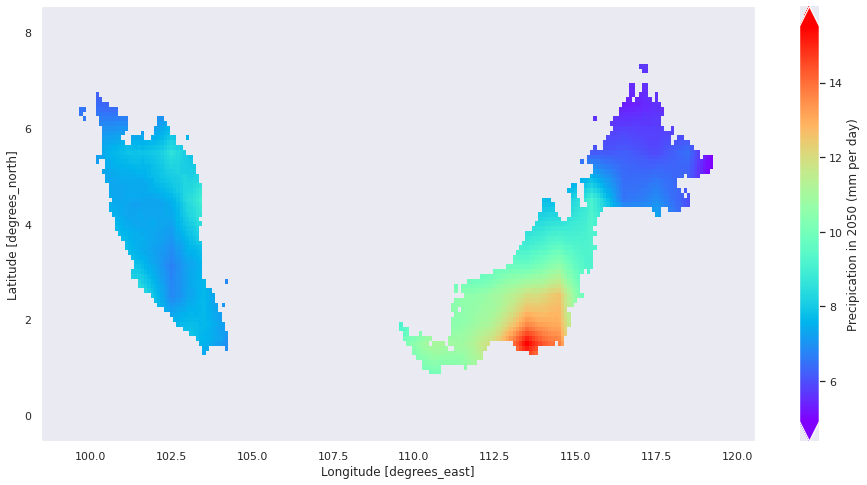

In [15]:
if VAR == 'Precipitation':
    tmp_var = predicted.mean('time') * 1000.

    countries_select = countries[countries.NAME_0==COUNTRY_NAME].geometry

    countries_mask_poly = regionmask.Regions(name = 'NAME_0', outlines = list(countries_select.geometry.values[i] for i in range(0,countries_select.shape[0])))

    mask = countries_mask_poly.mask(predicted.isel(time = 0), lat_name='lat', lon_name='lon')
    tmp_var = tmp_var.where(~np.isnan(mask))

    _=plt.figure(figsize=(16,8))
    ax = plt.axes()
    im=tmp_var.plot(ax=ax,cmap='rainbow',add_colorbar=False)
    # im = countries_select.plot(ax = ax, alpha = 0.8, facecolor = 'none', lw = 1)

    cb = plt.colorbar(im, orientation="vertical",label='Precipication in 2050 (mm per day)', extend='both')
    
if VAR == 'Temperature':
    tmp_var = predicted.mean('time') - 273.15 # change temp unit from Kelvin to Celcius

    countries_select = countries[countries.NAME_0==COUNTRY_NAME].geometry

    countries_mask_poly = regionmask.Regions(name = 'NAME_0', outlines = list(countries_select.geometry.values[i] for i in range(0,countries_select.shape[0])))

    mask = countries_mask_poly.mask(predicted.isel(time = 0), lat_name='lat', lon_name='lon')
    tmp_var = tmp_var.where(~np.isnan(mask))

    _=plt.figure(figsize=(16,8))
    ax = plt.axes()
    im=tmp_var.plot(ax=ax,cmap='rainbow',add_colorbar=False)
    # im = countries_select.plot(ax = ax, alpha = 0.8, facecolor = 'none', lw = 1)

    cb = plt.colorbar(im, orientation="vertical",label='Temperature in 2050 (C)', extend='both')
    
if VAR == 'Wind':
    tmp_var = predicted.mean('time')

    countries_select = countries[countries.NAME_0==COUNTRY_NAME].geometry

    countries_mask_poly = regionmask.Regions(name = 'NAME_0', outlines = list(countries_select.geometry.values[i] for i in range(0,countries_select.shape[0])))

    mask = countries_mask_poly.mask(predicted.isel(time = 0), lat_name='lat', lon_name='lon')
    tmp_var = tmp_var.where(~np.isnan(mask))

    _=plt.figure(figsize=(16,8))
    ax = plt.axes()
    im=tmp_var.plot(ax=ax,cmap='rainbow',add_colorbar=False)
    # im = countries_select.plot(ax = ax, alpha = 0.8, facecolor = 'none', lw = 1)

    cb = plt.colorbar(im, orientation="vertical",label='Wind in 2050 (m/s)', extend='both')
    
if VAR == 'Surge':
    tmp_var = (predicted.mean(dim="time") / nowadays.mean(dim="time") - 1.) * 42. * ((5.5-1.5)/(69-42))
    
    countries_select = countries[countries.NAME_0==COUNTRY_NAME].geometry.buffer(.5)

    countries_mask_poly = regionmask.Regions(name = 'NAME_0', outlines = list(countries_select.geometry.values[i] for i in range(0,countries_select.shape[0])))

    mask = countries_mask_poly.mask(predicted.isel(time = 0), lat_name='lat', lon_name='lon')
    tmp_var = tmp_var.where(~np.isnan(mask))

    _=plt.figure(figsize=(16,8))
    ax = plt.axes()
    im=tmp_var.plot(ax=ax,cmap='rainbow',add_colorbar=False)
    # im = countries_select.plot(ax = ax, alpha = 0.8, facecolor = 'none', lw = 1)

    cb = plt.colorbar(im, orientation="vertical",label='Surge change in 2050 (m)', extend='both')
    _=plt.title("The land should NOT be used for the surge analysis in this figure\nthe plotted area includes land and coastal region within 50-km ocean to coasts")